In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
df = pd.read_csv('data/car_price_prediction_.csv')
df = df.drop('Car ID', axis=1)

# Use One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=['Brand', 'Fuel Type', 'Transmission', 'Condition', 'Model'], drop_first=True)


# Outlier detection using Z-scores
z_thresh = 3
numerical_cols = ['Year', 'Engine Size', 'Mileage']
z_scores = np.abs(stats.zscore(df[numerical_cols]))
outliers = (z_scores > z_thresh).any(axis=1)
df_cleaned = df[~outliers]

# Scaling numerical features
scaler = MinMaxScaler()
df_cleaned[numerical_cols] = scaler.fit_transform(df_cleaned[numerical_cols])

# Define features and target variable
X = df_cleaned.drop(columns='Price', axis=1)
Y = df_cleaned['Price']

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

In [3]:
# Define the model
xgb_model = xgb.XGBRegressor(random_state=0)

# Fit the model using the training data
xgb_model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = xgb_model.predict(X_test)

In [4]:
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2 = r2_score(Y_test, Y_pred)

print(f"""
Mean Absolute Error: {mae:.2f}
Root Mean Squared Error: {rmse:.2f}
R² Score: {r2:.2f}
""")

mae_test = mean_absolute_error(Y_test, Y_pred)

# Calculate the mean of Y (target variable)
mean_y = Y_test.mean()

# Calculate the percentage of MAE relative to the mean of Y
mae_percentage = (mae_test / mean_y) * 100

print(f"The Mean Absolute Error is {mae_test:.2f}, which is {mae_percentage:.2f}% of the mean of Y.")
print(f"This means if our model makes a prediction it'll be +-{mae_percentage:.2f}% trustworthy")


Mean Absolute Error: 25620.73
Root Mean Squared Error: 30973.23
R² Score: -0.23

The Mean Absolute Error is 25620.73, which is 48.89% of the mean of Y.
This means if our model makes a prediction it'll be +-48.89% trustworthy


<Figure size 1000x1800 with 0 Axes>

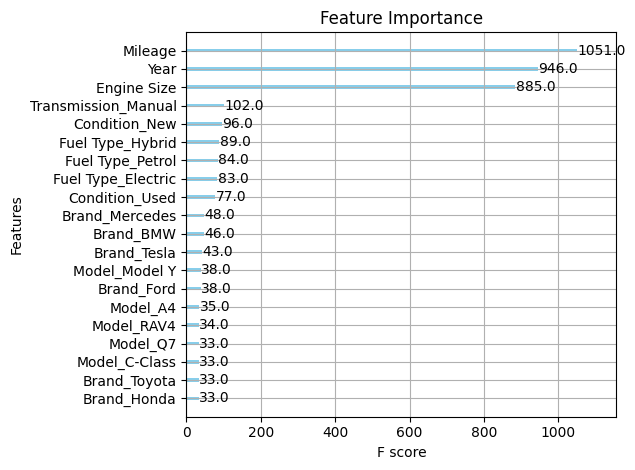

<Figure size 640x480 with 0 Axes>

In [5]:
plt.figure(figsize=(10, 18))  # Set the figure size

# Plot importance
xgb.plot_importance(xgb_model, 
                    importance_type='weight',  # You can choose 'weight', 'gain', or 'cover'
                    max_num_features=20,  # Show only the top 20 features
                    title='Feature Importance',
                    xlabel='F score',
                    ylabel='Features',
                    color='skyblue')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()
plt.savefig("results/ImportantFeatures.png")

In [6]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb_model, X, Y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-Validated MAE: {-cv_scores.mean():.2f}")


Cross-Validated MAE: 26008.50
